<a href="https://colab.research.google.com/github/hadwin-357/GCN/blob/main/Gnn_node_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

2.1.0+cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 63.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 34.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize (h, color):
  z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())
  plt.figure(figsize=(10,10))
  plt.scatter(z[:,0], z[:,1], s=70, c=color, cmap='Set2')
  plt.show()

In [ ]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='data/Planetoid', name='Cora', transform =NormalizeFeatures())

print(f'Dataset:{dataset}')
print(f'num of graphes:{len(dataset)}')
print(f'num of features:{dataset.num_features}')
print(f'num of classes: {dataset.num_classes}')

data =dataset[0]

print(data)
print(f'Number of Nodes:{data.num_nodes}')
print(f'Number of edges:{data.num_edges}')
print(f'Average node degrees:{data.num_edges / data.num_nodes: 2f}')
print(f'Number of training node: {data.train_mask.sum()}')
print(f'Has isolated nodes:{data.has_isolated_nodes()}')
print(f'Has self-loops:{data.has_self_loops()}')
print(f'is directional: {data.is_directed()}')

Processing...


Dataset:Cora()
num of graphes:1
num of features:1433
num of classes: 7
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of Nodes:2708
Number of edges:10556
Average node degrees: 3.898080
Number of training node: 140
Has isolated nodes:False
Has self-loops:False
is directional: False


Done!


In [ ]:
import torch
from torch.nn import Linear, ReLU
import torch.nn.functional as F

torch.manual_seed(42)

class MLP(torch.nn.Module):
  def __init__(self, hidden_channels):
    super().__init__()
    self.lin1 = Linear(dataset.num_features, hidden_channels)
    self.lin2 = Linear(hidden_channels, dataset.num_classes)
  def forward (self, x):
    x=self.lin1(x)
    x=x.relu()
    x=F.dropout(x,p=0.5, training=self.training)
    x=self.lin2(x)
    return x

model_0 =MLP(hidden_channels=16)
print(model_0)


MLP(
  (lin1): Linear(in_features=1433, out_features=16, bias=True)
  (lin2): Linear(in_features=16, out_features=7, bias=True)
)


In [ ]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

def train(model: torch.nn.Module, data, loss_fn:torch.nn.Module, optimizer:torch.optim.Optimizer):
  model.train()
  train_loss, train_acc = 0, 0
  out = model(data.x)
  loss = loss_fn(out[data.train_mask], data.y[data.train_mask])
  train_loss =loss
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  pred = out.argmax(dim=1)
  train_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
  train_acc = int(train_correct.sum()) / int(data.test_mask.sum())
  return train_loss, train_acc
def test(model: torch.nn.Module, data, loss_fn:torch.nn.Module):
  test_loss, test_acc = 0, 0
  model.eval()
  with torch.inference_mode():
    out = model(data.x)
    loss = loss_fn(out[data.train_mask], data.y[data.train_mask])
    test_loss=loss
    pred=out.argmax(dim=1)
    test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
    return test_loss, test_acc

loss_fn =torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(),lr=0.01, weight_decay =5e-4)
for epoch in range (1, 201):
  train_loss, train_acc = train(model_0, data, loss_fn=loss_fn, optimizer =optimizer)
  test_loss, test_acc=test(model_0, data,loss_fn=loss_fn)
  print(f'Epoch: {epoch} Train loss: {train_loss:3f} test loss:{test_loss}\n')
  print(f'Train accuracy: {train_acc} Test accuary: {test_acc}')


<IPython.core.display.Javascript object>

Epoch: 1 Train loss: 1.951259 test loss:1.9475311040878296

Train accuracy: 0.091 Test accuary: 0.091
Epoch: 2 Train loss: 1.947481 test loss:1.9430460929870605

Train accuracy: 0.096 Test accuary: 0.091
Epoch: 3 Train loss: 1.944163 test loss:1.9377018213272095

Train accuracy: 0.097 Test accuary: 0.091
Epoch: 4 Train loss: 1.937484 test loss:1.9312471151351929

Train accuracy: 0.096 Test accuary: 0.095
Epoch: 5 Train loss: 1.930559 test loss:1.923984169960022

Train accuracy: 0.119 Test accuary: 0.097
Epoch: 6 Train loss: 1.923584 test loss:1.9157832860946655

Train accuracy: 0.138 Test accuary: 0.105
Epoch: 7 Train loss: 1.917774 test loss:1.9069865942001343

Train accuracy: 0.13 Test accuary: 0.112
Epoch: 8 Train loss: 1.906622 test loss:1.8975391387939453

Train accuracy: 0.142 Test accuary: 0.12
Epoch: 9 Train loss: 1.897109 test loss:1.8874319791793823

Train accuracy: 0.138 Test accuary: 0.132
Epoch: 10 Train loss: 1.888231 test loss:1.8766037225723267

Train accuracy: 0.152 Te

In [ ]:
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
  def __init__(self, hidden_channels):
    super().__init__()
    torch.manual_seed(32)
    self.conv1=GCNConv(dataset.num_features, hidden_channels)
    self.conv2=GCNConv(hidden_channels,dataset.num_classes)

  def forward(self, x, edge_index):
    x = self.conv1(x, edge_index)
    x = x.relu()
    x = F.dropout(x, p=0.5, training=self.training)
    x = self.conv2(x, edge_index)
    return x
model_1=GCN(hidden_channels=16)
print(model_1)


GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


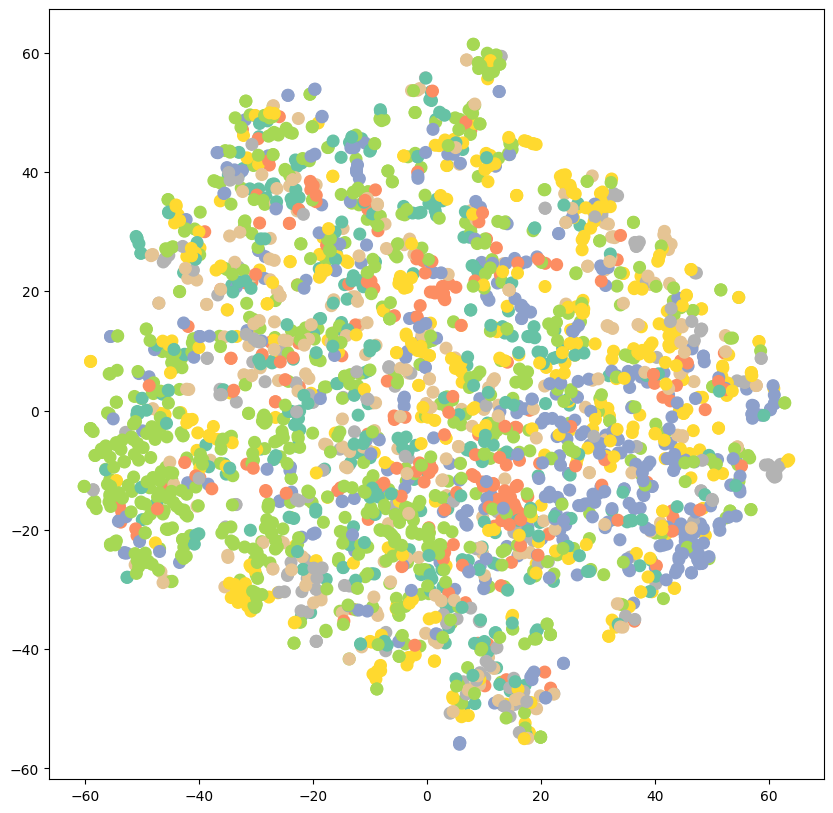

In [ ]:
model_1.eval()
out = model_1(data.x, data.edge_index)
visualize(out, color = data.y)

In [ ]:
def train(model: torch.nn.Module, data, loss_fn:torch.nn.Module, optimizer:torch.optim.Optimizer):
  model.train()
  train_loss, train_acc = 0, 0
  out = model(data.x, data.edge_index)
  loss = loss_fn(out[data.train_mask], data.y[data.train_mask])
  train_loss =loss
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  pred = out.argmax(dim=1)
  train_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
  train_acc = int(train_correct.sum()) / int(data.test_mask.sum())
  return train_loss, train_acc
def test(model: torch.nn.Module, data, loss_fn:torch.nn.Module):
  test_loss, test_acc = 0, 0
  model.eval()
  with torch.inference_mode():
    out = model(data.x, data.edge_index)
    loss = loss_fn(out[data.train_mask], data.y[data.train_mask])
    test_loss=loss
    pred=out.argmax(dim=1)
    test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
    return test_loss, test_acc

loss_fn =torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_1.parameters(),lr=0.01, weight_decay =5e-4)

for epoch in range (1, 201):
  train_loss, train_acc = train(model_1, data, loss_fn=loss_fn, optimizer =optimizer)
  test_loss, test_acc=test(model_1, data,loss_fn=loss_fn)
  print(f'Epoch: {epoch} Train loss: {train_loss:3f} test loss:{test_loss}\n')
  print(f'Train accuracy: {train_acc} Test accuary: {test_acc}')

Epoch: 1 Train loss: 1.945689 test loss:1.9403564929962158

Train accuracy: 0.155 Test accuary: 0.095
Epoch: 2 Train loss: 1.940693 test loss:1.9340012073516846

Train accuracy: 0.101 Test accuary: 0.257
Epoch: 3 Train loss: 1.934688 test loss:1.9264252185821533

Train accuracy: 0.241 Test accuary: 0.605
Epoch: 4 Train loss: 1.927269 test loss:1.918424129486084

Train accuracy: 0.405 Test accuary: 0.455
Epoch: 5 Train loss: 1.919708 test loss:1.9096176624298096

Train accuracy: 0.372 Test accuary: 0.533
Epoch: 6 Train loss: 1.908547 test loss:1.9002488851547241

Train accuracy: 0.415 Test accuary: 0.625
Epoch: 7 Train loss: 1.901283 test loss:1.8902593851089478

Train accuracy: 0.449 Test accuary: 0.644
Epoch: 8 Train loss: 1.890578 test loss:1.8796344995498657

Train accuracy: 0.481 Test accuary: 0.653
Epoch: 9 Train loss: 1.876591 test loss:1.8684358596801758

Train accuracy: 0.496 Test accuary: 0.662
Epoch: 10 Train loss: 1.867885 test loss:1.8566988706588745

Train accuracy: 0.476 

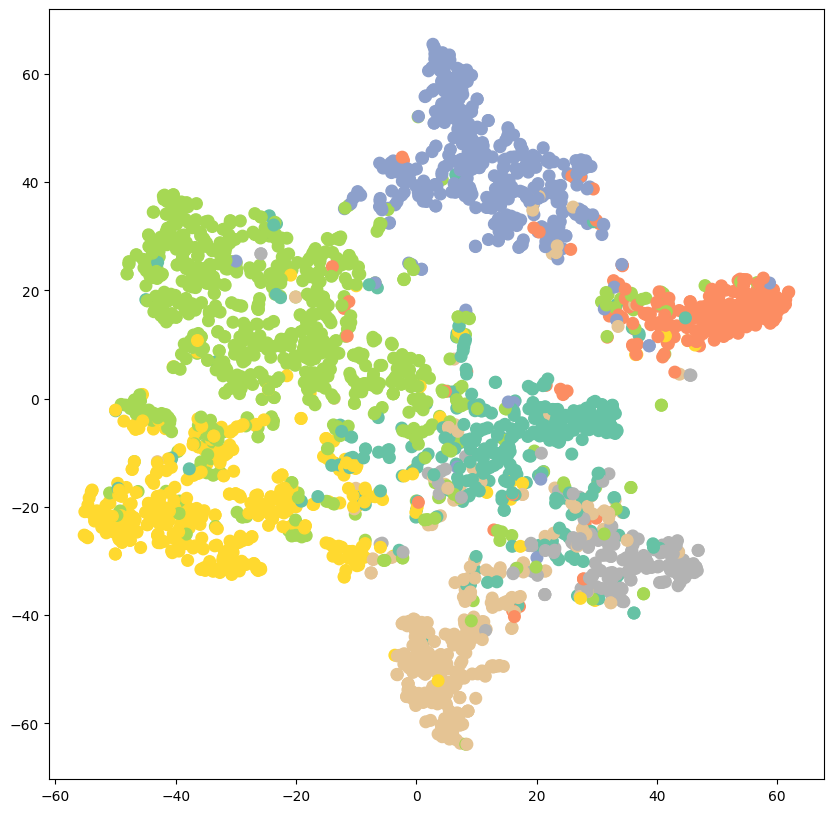

In [ ]:
model_1.eval()

out=model_1(data.x, data.edge_index)
visualize(out, color = data.y)

In [ ]:
model_2=GCN(hidden_channels =32)
model_2

GCN(
  (conv1): GCNConv(1433, 32)
  (conv2): GCNConv(32, 7)
)

In [ ]:
loss_fn =torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_2.parameters(),lr=0.01, weight_decay =5e-4)

for epoch in range (1, 201):
  train_loss, train_acc = train(model_2, data, loss_fn=loss_fn, optimizer =optimizer)
  test_loss, test_acc=test(model_2, data,loss_fn=loss_fn)
  print(f'Epoch: {epoch} Train loss: {train_loss:3f} test loss:{test_loss}\n')
  print(f'Train accuracy: {train_acc} Test accuary: {test_acc}')

Epoch: 1 Train loss: 1.946121 test loss:1.9382723569869995

Train accuracy: 0.133 Test accuary: 0.381
Epoch: 2 Train loss: 1.938508 test loss:1.929194688796997

Train accuracy: 0.281 Test accuary: 0.499
Epoch: 3 Train loss: 1.929001 test loss:1.9166351556777954

Train accuracy: 0.366 Test accuary: 0.496
Epoch: 4 Train loss: 1.916984 test loss:1.9026236534118652

Train accuracy: 0.403 Test accuary: 0.478
Epoch: 5 Train loss: 1.901770 test loss:1.8882060050964355

Train accuracy: 0.387 Test accuary: 0.549
Epoch: 6 Train loss: 1.889587 test loss:1.8732541799545288

Train accuracy: 0.415 Test accuary: 0.647
Epoch: 7 Train loss: 1.875455 test loss:1.8570574522018433

Train accuracy: 0.454 Test accuary: 0.681
Epoch: 8 Train loss: 1.849303 test loss:1.8394285440444946

Train accuracy: 0.5 Test accuary: 0.716
Epoch: 9 Train loss: 1.838579 test loss:1.8207132816314697

Train accuracy: 0.524 Test accuary: 0.728
Epoch: 10 Train loss: 1.822276 test loss:1.8010249137878418

Train accuracy: 0.548 Te

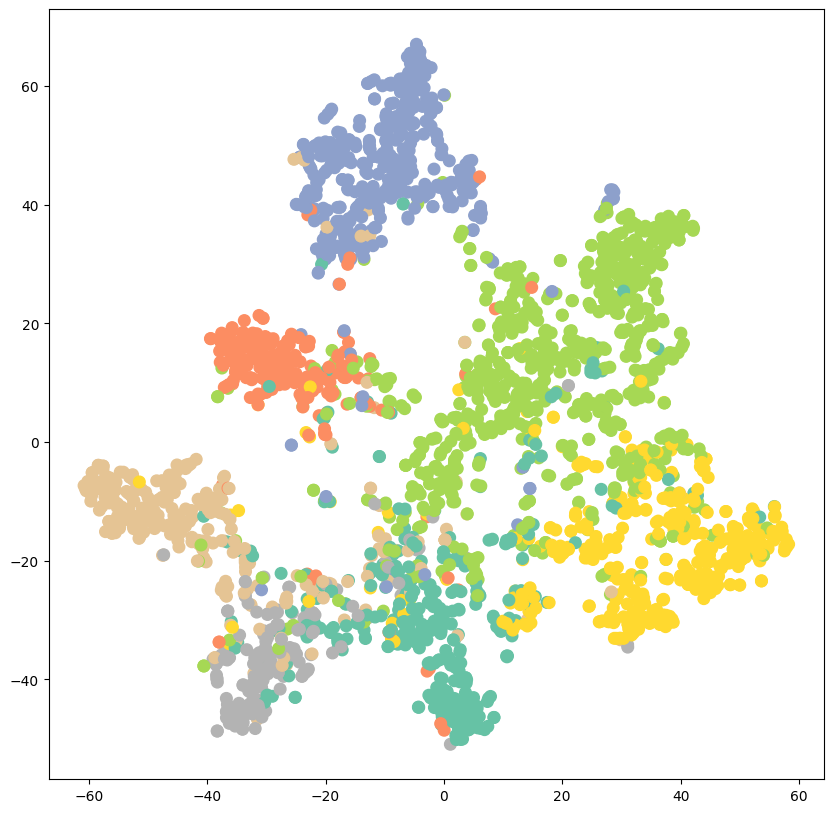

In [ ]:
model_2.eval()

out=model_2(data.x, data.edge_index)
visualize(out, color = data.y)

In [ ]:
from torch_geometric.nn import GATConv


class GAT(torch.nn.Module):
    def __init__(self, hidden_channels, heads):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GATConv(dataset.num_features ,hidden_channels, heads=heads,concat =False ) # TODO
        self.conv2 = GATConv(hidden_channels, dataset.num_classes,heads=heads,concat =False)  # TODO

    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model_3 = GAT(hidden_channels=8, heads=8)
print(model_3)

GAT(
  (conv1): GATConv(1433, 8, heads=8)
  (conv2): GATConv(8, 7, heads=8)
)


In [ ]:
import torch
from torch.nn import Linear, ReLU
import torch.nn.functional as F
def train(model: torch.nn.Module, data, loss_fn:torch.nn.Module, optimizer:torch.optim.Optimizer):
  model.train()
  train_loss, train_acc = 0, 0
  out = model(data.x, data.edge_index)
  loss = loss_fn(out[data.train_mask], data.y[data.train_mask])
  train_loss =loss
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  pred = out.argmax(dim=1)
  train_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
  train_acc = int(train_correct.sum()) / int(data.test_mask.sum())
  return train_loss, train_acc
def test(model: torch.nn.Module, data, loss_fn:torch.nn.Module):
  test_loss, test_acc = 0, 0
  model.eval()
  with torch.inference_mode():
    out = model(data.x, data.edge_index)
    loss = loss_fn(out[data.train_mask], data.y[data.train_mask])
    test_loss=loss
    pred=out.argmax(dim=1)
    test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
    return test_loss, test_acc

loss_fn =torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_3.parameters(),lr=0.01, weight_decay =5e-4)

for epoch in range (1, 201):
  train_loss, train_acc = train(model_3, data, loss_fn=loss_fn, optimizer =optimizer)
  test_loss, test_acc=test(model_3, data,loss_fn=loss_fn)
  print(f'Epoch: {epoch} Train loss: {train_loss:3f} test loss:{test_loss}\n')
  print(f'Train accuracy: {train_acc} Test accuary: {test_acc}')

Epoch: 1 Train loss: 1.945892 test loss:1.945732593536377

Train accuracy: 0.159 Test accuary: 0.149
Epoch: 2 Train loss: 1.945691 test loss:1.9454877376556396

Train accuracy: 0.159 Test accuary: 0.154
Epoch: 3 Train loss: 1.945407 test loss:1.9453027248382568

Train accuracy: 0.156 Test accuary: 0.263
Epoch: 4 Train loss: 1.945366 test loss:1.9451169967651367

Train accuracy: 0.196 Test accuary: 0.349
Epoch: 5 Train loss: 1.944562 test loss:1.9449139833450317

Train accuracy: 0.259 Test accuary: 0.391
Epoch: 6 Train loss: 1.944909 test loss:1.9447076320648193

Train accuracy: 0.273 Test accuary: 0.354
Epoch: 7 Train loss: 1.945243 test loss:1.944517731666565

Train accuracy: 0.257 Test accuary: 0.111
Epoch: 8 Train loss: 1.945192 test loss:1.9443353414535522

Train accuracy: 0.141 Test accuary: 0.208
Epoch: 9 Train loss: 1.943978 test loss:1.9441344738006592

Train accuracy: 0.15 Test accuary: 0.241
Epoch: 10 Train loss: 1.944728 test loss:1.9439244270324707

Train accuracy: 0.148 Te

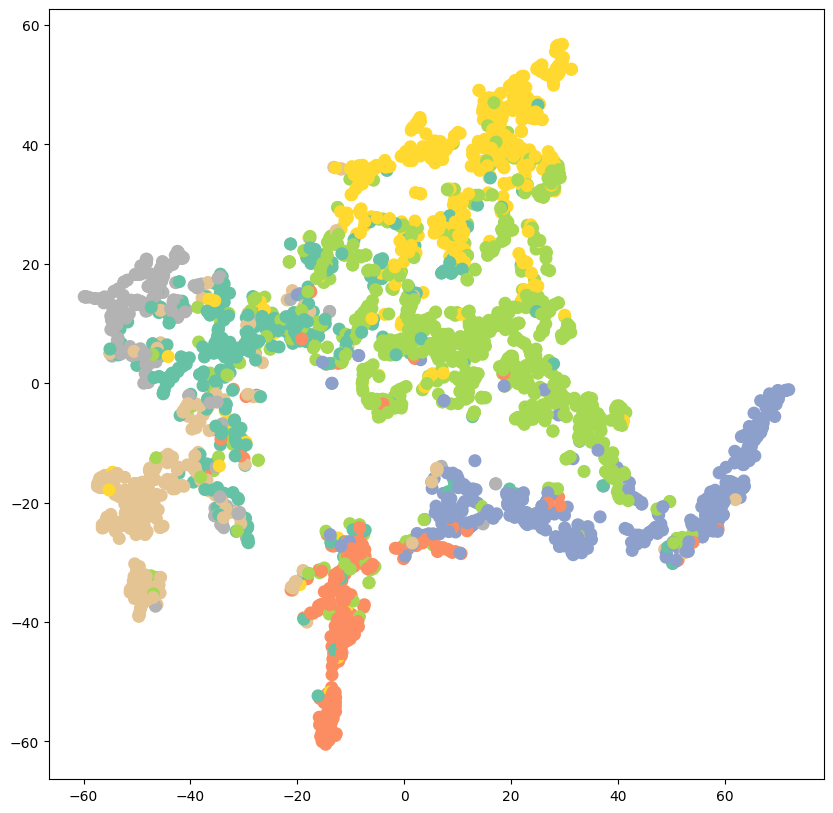

In [ ]:
model_3.eval()

out = model_3(data.x, data.edge_index)
visualize(out, color=data.y)